# Préparation des données
## Import des données et méthodes

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy             as sp
import sklearn.metrics   as metrics
import sklearn.model_selection

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 20})

data = pd.read_csv("notes.csv", sep=",") #lire fichier csv
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


##  Gestion des valeurs extremes

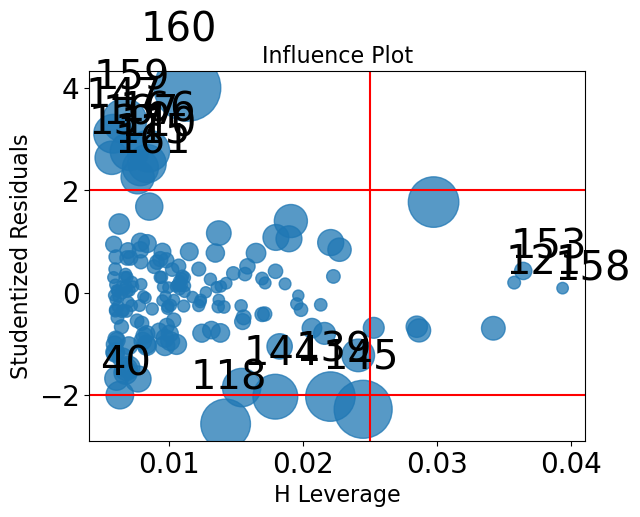

In [2]:
# détection des outliers

from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.api as sm
import statsmodels.stats as stats

model = sm.OLS(data['diagonal'], data[['margin_low', 'length']])
results = model.fit()

influence_plot(results, criterion="cooks")
plt.axhline(y=2, color='r')
plt.axhline(y=-2, color='r')
plt.axvline(x=0.025, color='r')
plt.show()


In [3]:
# index des outliers

influence = stats.outliers_influence.OLSInfluence(results)
influence = influence.summary_frame()[['cooks_d', 'hat_diag', 'standard_resid']]

# Cook's distance : first filter
cook_distance_filter = influence[influence['cooks_d']>= 0.012].copy()

# standardized residuals : second filter
std_residuals_filter = influence[(influence['standard_resid'] <= -2)|
                                 (influence['standard_resid'] >= 2)].copy()

# H leverage : third filter
h_leverage_filter = influence[influence['hat_diag']>= 0.025]

# outliers filter
outliers = pd.concat([cook_distance_filter, std_residuals_filter, h_leverage_filter])
np.unique(outliers.index)


array([ 40,  69, 110, 115, 116, 117, 118, 121, 131, 134, 135, 137, 139,
       142, 144, 145, 147, 150, 151, 153, 158, 159, 160, 161, 166, 167],
      dtype=int64)

## Analyse préliminaire des données
### Avec Outliers

False    24
True      2
Name: is_genuine, dtype: int64


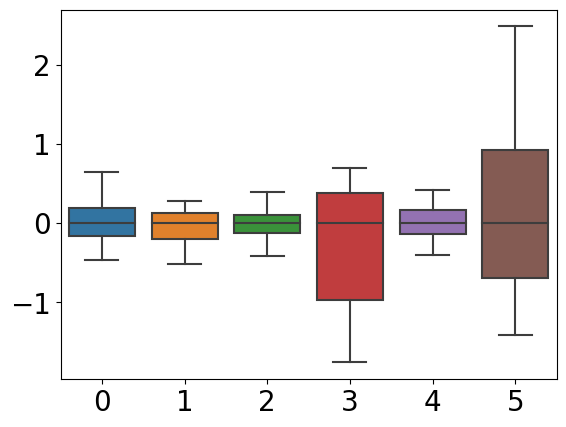

In [4]:


from sklearn.preprocessing import RobustScaler
scaled_outliers = RobustScaler(with_centering=True, with_scaling=False)\
                              .fit_transform(data.loc[np.unique(outliers.index)])

sns.boxplot(data=scaled_outliers[:, 1:], showfliers=False);
print(data.loc[np.unique(outliers.index)]['is_genuine'].value_counts())


### Sans outliers

In [5]:
# élimination des outliers des données
data = data.drop(index=np.unique(outliers.index))
scaled_outliers

array([[ 1.   , -0.34 , -0.46 , -0.75 , -1.09 , -0.405,  2.485],
       [ 1.   ,  0.09 , -0.2  ,  0.05 , -1.5  ,  0.145,  0.375],
       [ 0.   ,  0.25 , -0.01 ,  0.1  , -1.51 ,  0.205, -0.115],
       [ 0.   ,  0.58 ,  0.01 , -0.16 , -1.45 ,  0.185,  0.115],
       [ 0.   , -0.07 ,  0.2  , -0.05 ,  0.32 , -0.025,  0.525],
       [ 0.   , -0.1  ,  0.05 , -0.09 ,  0.42 , -0.075,  0.405],
       [ 0.   , -0.02 ,  0.08 ,  0.06 , -0.07 ,  0.125,  2.255],
       [ 0.   ,  0.22 ,  0.19 ,  0.12 ,  0.61 , -0.135, -0.175],
       [ 0.   , -0.29 , -0.14 , -0.24 ,  0.58 ,  0.175,  0.165],
       [ 0.   , -0.47 , -0.27 ,  0.09 , -0.04 ,  0.175,  1.415],
       [ 0.   ,  0.01 , -0.19 , -0.01 ,  0.43 ,  0.135,  0.525],
       [ 0.   ,  0.09 ,  0.25 ,  0.14 , -0.98 ,  0.165, -0.745],
       [ 0.   , -0.25 ,  0.06 ,  0.09 ,  0.24 , -0.125,  1.455],
       [ 0.   , -0.16 , -0.13 ,  0.17 ,  0.04 ,  0.025, -0.855],
       [ 0.   , -0.29 , -0.51 , -0.24 ,  0.08 , -0.225,  1.565],
       [ 0.   ,  0.1  ,  

True     98
False    46
Name: is_genuine, dtype: int64


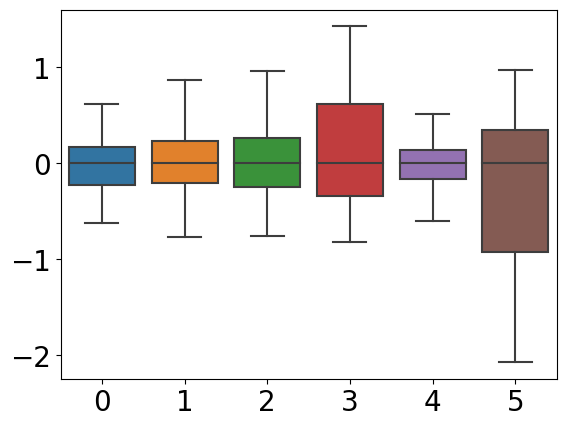

In [6]:
# RobustScaler : centrer par la médiane, robuste aux outliers.
# pas de réduction car la variance pourra permettre de detecter les faux billets

from sklearn.preprocessing import RobustScaler
scaled_data = RobustScaler(with_centering=True, with_scaling=False).fit_transform(data)

sns.boxplot(data=scaled_data[:, 1:],  showfliers=False);
print(data['is_genuine'].value_counts())
# 0, 1,2, 4 même variabilité

### Comparaison des valeurs avec une variance élevée

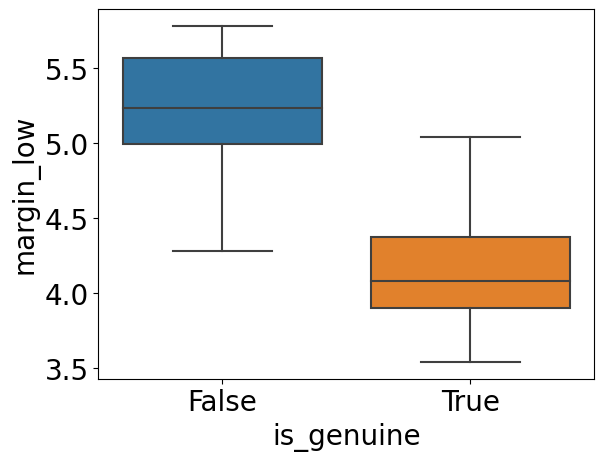

In [7]:

sns.boxplot(x='is_genuine', y='margin_low', data=data);


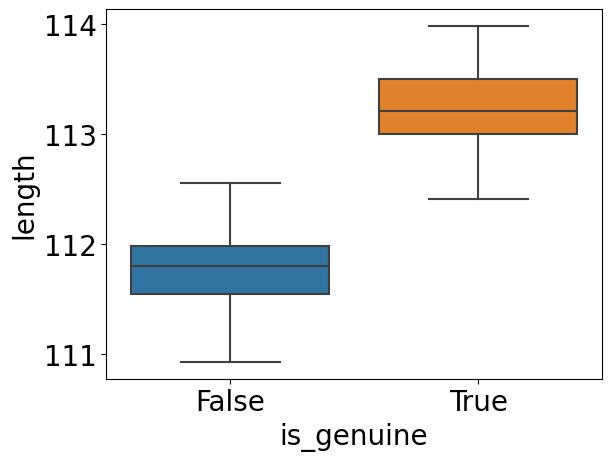

In [8]:
sns.boxplot(x='is_genuine', y='length', data=data);


### Vérification Loi normal

In [9]:
from scipy import stats
def ks_shapiro_jb(vector):
    
    critical_threshold = 0.001
    shapiro_ok = False
    ks_ok = False
    jb_ok = False
    
    X = vector.values.reshape(-1,1)
    standardized_X = RobustScaler().fit_transform(X)
    
#     shapiro test
    echantillon_standardized_X = np.random.choice(standardized_X.reshape(-1), size=30, replace=False)

    if stats.shapiro(echantillon_standardized_X)[1] >= critical_threshold:
        shapiro_ok = True
        
#     kolmogorov/smirnov test
# The one-sample test performs a test of the distribution F(x) of an observed random variable against 
# a given distribution G(x). Under the null hypothesis, the two distributions are identical, F(x)=G(x). 

    random_normal = np.random.normal(loc=standardized_X.mean(), 
                                     scale=standardized_X.std(), 
                                     size=(standardized_X.shape[0], 1))

    if stats.kstest(standardized_X.reshape(-1), random_normal.reshape(-1), 
                    N=standardized_X.shape[0])[1] >= critical_threshold :
        ks_ok = True

#   test de jarque bera 
# Note that this test only works for a large enough number of data samples (>2000) as the test statistic 
# asymptotically has a Chi-squared distribution with 2 degrees of freedom.

    if stats.jarque_bera(standardized_X.reshape(-1))[1] >= critical_threshold:
        jb_ok = True

    if (shapiro_ok==True) & (ks_ok==True) & (jb_ok==True): 
        return True
    else :
        return False

In [10]:
ks_shapiro_jb(data["margin_low"])

True

In [11]:
ks_shapiro_jb(data["length"])

True

In [12]:
group_1 = data[data['is_genuine']==True]
group_1 = group_1/group_1.std()

group_2 = data[data['is_genuine']==False]
group_2 = group_2/group_2.std()

sp.stats.ttest_ind(group_1, group_2)[1][[4,6]]

F:\w10\Programme\Anaconda\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([1.42352306e-009, 7.90361274e-164])

In [13]:
# Les groupes sont statistiquement différents selon les données présentes.
# scaled_data[:,[0,1,2,3,4,5]]

## Analyse de corrélation (Student)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.16,0.865,1.05,0.165,-0.275,-0.175
1,-0.30,-0.255,-0.20,-0.345,-0.295,0.285
2,-0.14,-0.235,-0.14,0.045,-0.285,0.835
3,-0.17,-0.215,-0.25,-0.625,-0.045,0.625
4,0.08,-0.295,-0.15,0.685,-0.895,0.545
...,...,...,...,...,...,...
139,-0.19,0.075,0.26,1.415,0.135,-1.735
140,-0.54,0.265,0.07,1.375,-0.025,-1.185
141,0.14,0.235,0.55,0.885,0.415,-1.225
142,-0.15,-0.025,-0.02,0.375,0.385,-1.135


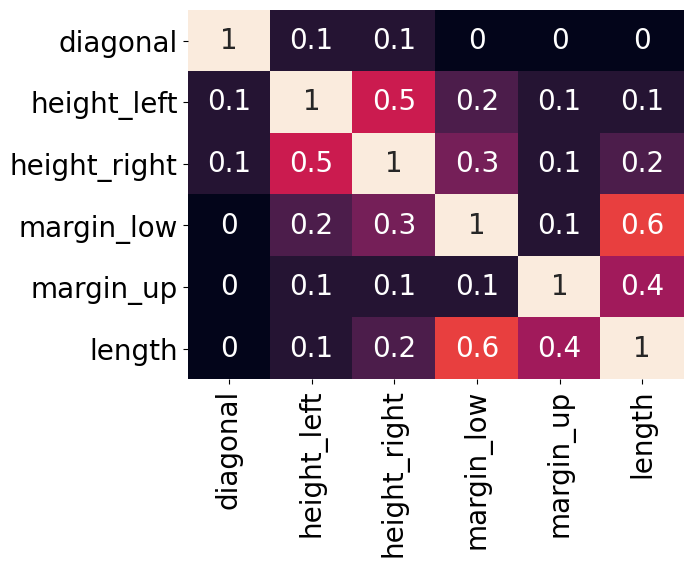

In [14]:
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

plt.figure(dpi=100)
sns.heatmap((scaled_data.iloc[:, 1:7].corr()**2).round(1), cbar=False, annot=True);
scaled_data.iloc[:, 1:7]

In [15]:
# billet faux à une forte relation avec 'margin_low' et 'length'

## Préparation en vue de la réalisation d'une ACP
### Définition des méthodes

In [16]:
def pca_transformation(matrix, n_components):
    
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import RobustScaler
    
    scaled_matrix = RobustScaler(with_centering=True, with_scaling=False).fit_transform(matrix)

    pca = PCA(n_components=n_components)
    pca.fit(scaled_matrix)

    components = pd.DataFrame(pca.components_, 
                              columns=matrix.columns, 
                              index=np.arange(1, pca.components_.shape[0]+1))
    
    return components, pca

def pca_scree(pca, savefig):
    
    # scree
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.xlabel("Composantes")
    plt.ylabel("% de Variance")

    # kaiser mean criterion
    kaiser_criterion = pca.explained_variance_ratio_.mean()
    plt.axhline(y=(pca.explained_variance_ratio_.mean()*100), color='r')
    
    # dumping graph
    if savefig:
        plt.tight_layout()
        plt.savefig('P6_03_screeplot.png')

    plt.show()

def pca_correlation_circle(pca, component_plane, columns, savefig):
    
    # component_plane transformation
    component_plane = np.array(component_plane)
    component_plane -= 1
    
    # initialisation de la figure
    fig, ax = plt.subplots(figsize=(7,7))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    
    # affichage du cercle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
    plt.gca().add_artist(circle)
   
    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # affichage des flèches
    plt.quiver(np.zeros(pca.components_.shape[1]), 
               np.zeros(pca.components_.shape[1]),
               pca.components_[component_plane[0],:], pca.components_[component_plane[1],:], 
               angles='xy', scale_units='xy', scale=1, color="grey")
            
    # affichage des noms des variables   
    for i,(x, y) in enumerate(pca.components_[[component_plane[0],component_plane[1]]].T):
        plt.text(x, y, columns.columns[i], 
                 fontsize='15', ha='center', va='bottom', color="red")

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(component_plane[0]+1, int(round(100*pca.explained_variance_ratio_[component_plane[0]],0))))
    plt.ylabel('F{} ({}%)'.format(component_plane[1]+1, int(round(100*pca.explained_variance_ratio_[component_plane[1]],0))))
    
    # dumping graph
    if savefig:
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.savefig('P6_04_correlation_circle_'+ str(component_plane[0] + 1) + '_' 
                    + str(component_plane[1] + 1) + '.png')
    
    plt.show()
    
    
def pca_factorial_plane(pca, component_plane, groups, columns, labels, centroids, savefig):
    
    import matplotlib.colors as colors
    
    # component_plane transformation
    component_plane = np.array(component_plane)
    component_plane -= 1
    
    # matrix preparation
    matrix = pca.fit_transform(columns)
    
    # figure preparation
    fig = plt.figure(figsize=(7,7))
    max_dimension = 3
    plt.xlim([-max_dimension, max_dimension])
    plt.ylim([-max_dimension, max_dimension])
    
    # components axes
    plt.plot([-100, 100], [0, 0], color='grey', ls='--', alpha=0.3)
    plt.plot([0, 0], [-100, 100], color='grey', ls='--', alpha=0.3)
    
    cmap = colors.LinearSegmentedColormap.from_list('', ['lightcoral','mediumseagreen'])
    plt.scatter(matrix[:, component_plane[0]], matrix[:, component_plane[1]], c=groups, cmap=cmap)  
    
    # centroids visual
    if centroids:
        
        # centroids computation
        centroids = np.concatenate([matrix,np.array(groups, dtype=int).reshape(-1, 1)], axis=1)
        centroids = pd.DataFrame(centroids).groupby(3).median()
        
        # red dots
        plt.scatter(centroids.iloc[:, component_plane[0]], centroids.iloc[:, component_plane[1]], 
                    c='black', alpha=0.7)
        
        # text
        [plt.text(x=centroids.iloc[i, component_plane[0]], 
                  y=centroids.iloc[i, component_plane[1]], 
                  s=int(centroids.index[i]), 
                  c='black',
                  fontsize=20) for i in np.arange(0, centroids.shape[0])];
                    
    # naming dots
    if labels:
        [plt.text(x=matrix[i, component_plane[0]], 
                  y=matrix[i, component_plane[1]], 
                  s=columns.index[i], 
                  c='r',
                  fontsize=8, alpha=0.7) for i in np.arange(0, columns.shape[0])];

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(component_plane[0]+1, int(round(100*pca.explained_variance_ratio_[component_plane[0]],0))))
    plt.ylabel('F{} ({}%)'.format(component_plane[1]+1, int(round(100*pca.explained_variance_ratio_[component_plane[1]],0))))
    
    # dumping graph
    if savefig:
        plt.tight_layout()
        plt.savefig('P6_05_factorial_plane_'+ str(component_plane[0] + 1) + '_' 
                    + str(component_plane[1] + 1) + '.png')
    plt.show()

### Analyse de la variance par composantes

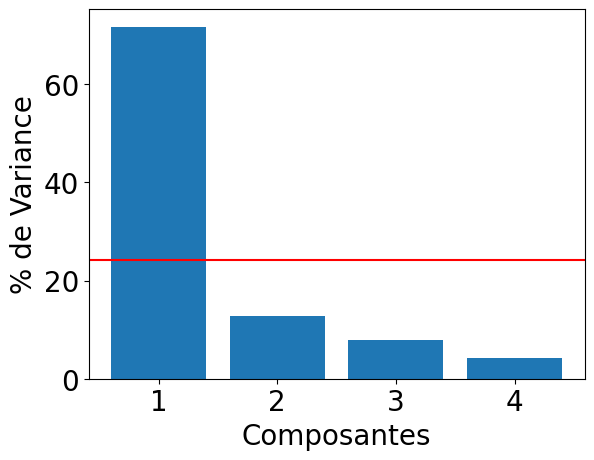

In [17]:
components, pca = pca_transformation(data.iloc[:, 1:], 0.95)

pca_scree(pca, savefig=False)

### réalisation du cercle de corrélation

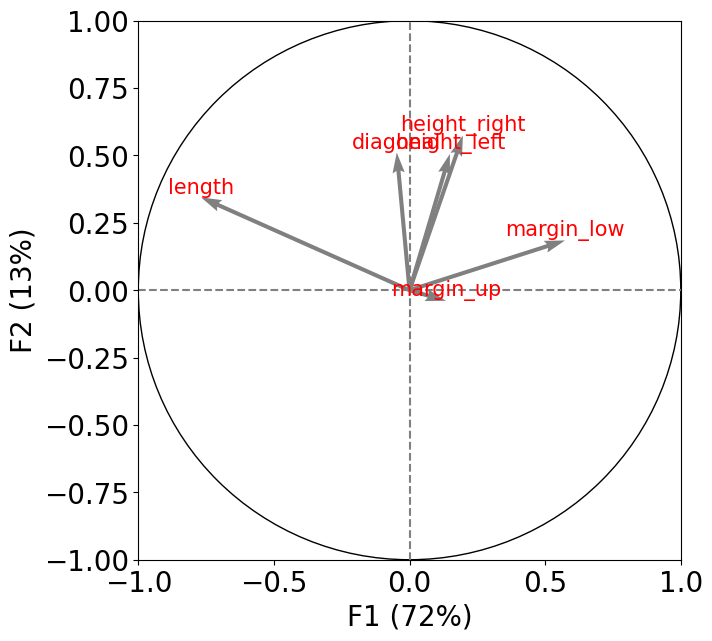

In [18]:
pca_correlation_circle(pca, [1, 2], data.iloc[:, 1:], savefig=False)


### Analyses et gestion des composantes superflu

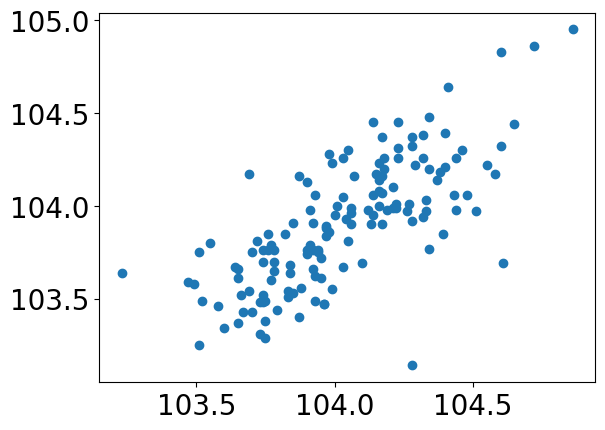

In [19]:

plt.scatter(data['height_left'], data['height_right']);
# height_right / height_left : même variance expliquée car variables corrélées, suppression height_left



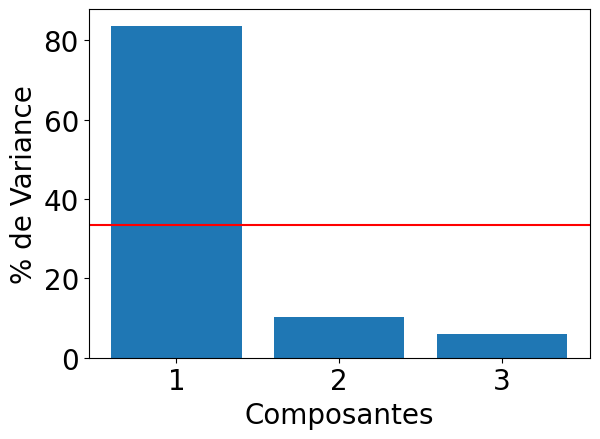

In [20]:
chosen_columns = data[['length', 'margin_low', 'height_right']]

components, pca = pca_transformation(chosen_columns, 0.95)

pca_scree(pca, savefig=True)

### Réalisation du cercle de corrélation après élimination des données non pertinente

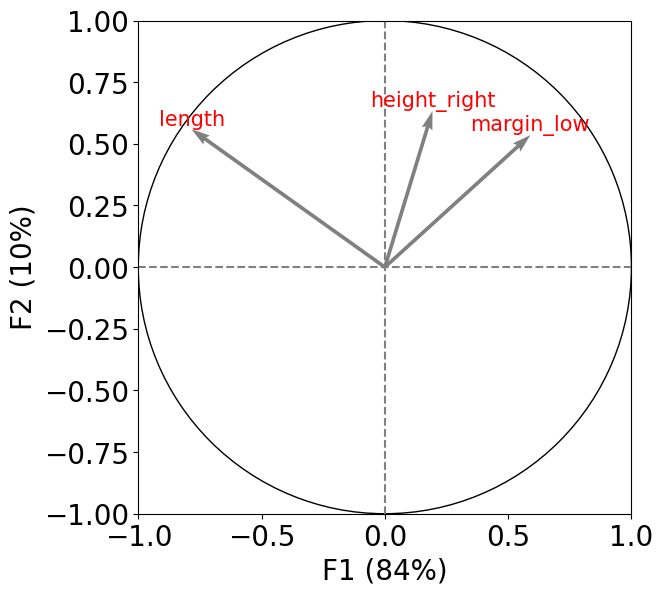

In [21]:
pca_correlation_circle(pca, [1, 2], chosen_columns, savefig=True)

### Représentation des individus dans les plans factoriels

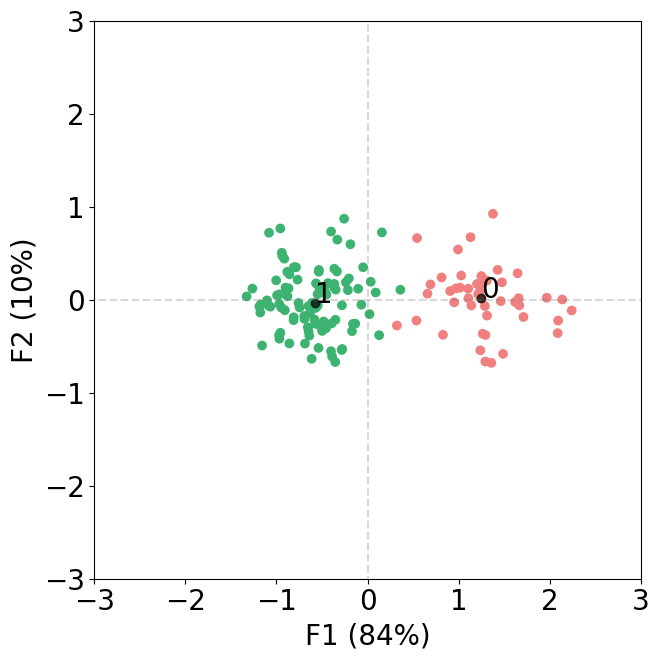

In [22]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=data['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=True)


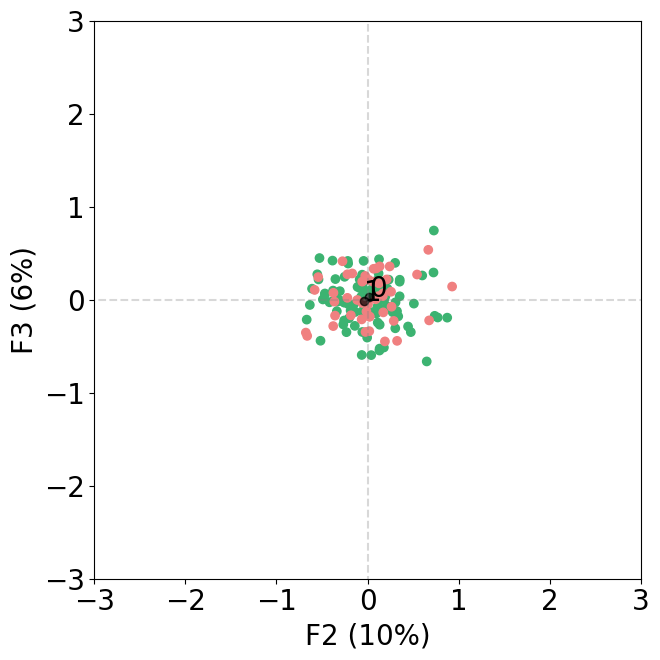

In [23]:
pca_factorial_plane(pca=pca, component_plane=[2, 3], groups=data['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=True)

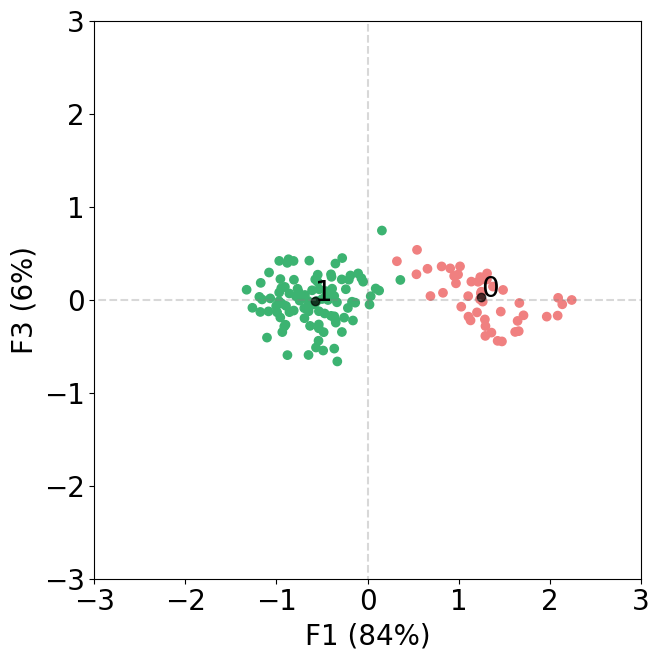

In [24]:
pca_factorial_plane(pca=pca, component_plane=[1, 3], groups=data['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=True)

In [25]:
# création F1 et F2
def pca_components(components, matrix, dataframe):
    
    from sklearn.preprocessing import RobustScaler
    
    scaled_matrix = RobustScaler(with_centering=True, with_scaling=False).fit_transform(matrix)
   
    F1 = (  scaled_matrix[:, 0] * components.iloc[0, 0] 
          + scaled_matrix[:, 1] * components.iloc[0, 1]
          + scaled_matrix[:, 2] * components.iloc[0, 2])

    F2 = (  scaled_matrix[:, 0] * components.iloc[1, 0] 
          + scaled_matrix[:, 1] * components.iloc[1, 1]
          + scaled_matrix[:, 2] * components.iloc[1, 2])

    dataframe['F1'] = F1
    dataframe['F2'] = F2
    
    
components, _ = pca_transformation(chosen_columns, 0.95)
pca_components(components, chosen_columns, data)
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0.437301,0.655023
1,True,171.67,103.74,103.70,4.01,2.87,113.29,-0.465620,-0.152002
2,True,171.83,103.76,103.76,4.40,2.88,113.84,-0.655006,0.402376
3,True,171.80,103.78,103.65,3.73,3.12,113.63,-0.907029,-0.143509
4,True,172.05,103.70,103.75,5.04,2.27,113.55,-0.051925,0.576686
...,...,...,...,...,...,...,...,...,...
163,False,171.78,104.07,104.16,5.77,3.30,111.27,2.245264,-0.047670
164,False,171.43,104.26,103.97,5.73,3.14,111.82,1.753843,0.118185
165,False,172.11,104.23,104.45,5.24,3.58,111.78,1.588715,0.137144
168,False,171.82,103.97,103.88,4.73,3.55,111.87,1.107130,-0.446418


In [26]:
data.iloc[:, [0, 6, 4, 3]]

,is_genuine,length,margin_low,height_right
0,True,112.83,4.52,104.95
1,True,113.29,4.01,103.70
2,True,113.84,4.40,103.76
3,True,113.63,3.73,103.65
4,True,113.55,5.04,103.75
...,...,...,...,...
163,False,111.27,5.77,104.16
164,False,111.82,5.73,103.97
165,False,111.78,5.24,104.45
168,False,111.87,4.73,103.88


### analyses croisées des composantes et des coordonnées dans le 1er plan factoriel

[3.05012644 0.64937173 0.19975952 0.10074231]
[0.76253161 0.16234293 0.04993988 0.02518558]
la 1er composante (length) représente 76% de l'information disponible; avec les 2 première composante nous avons 92% des informations


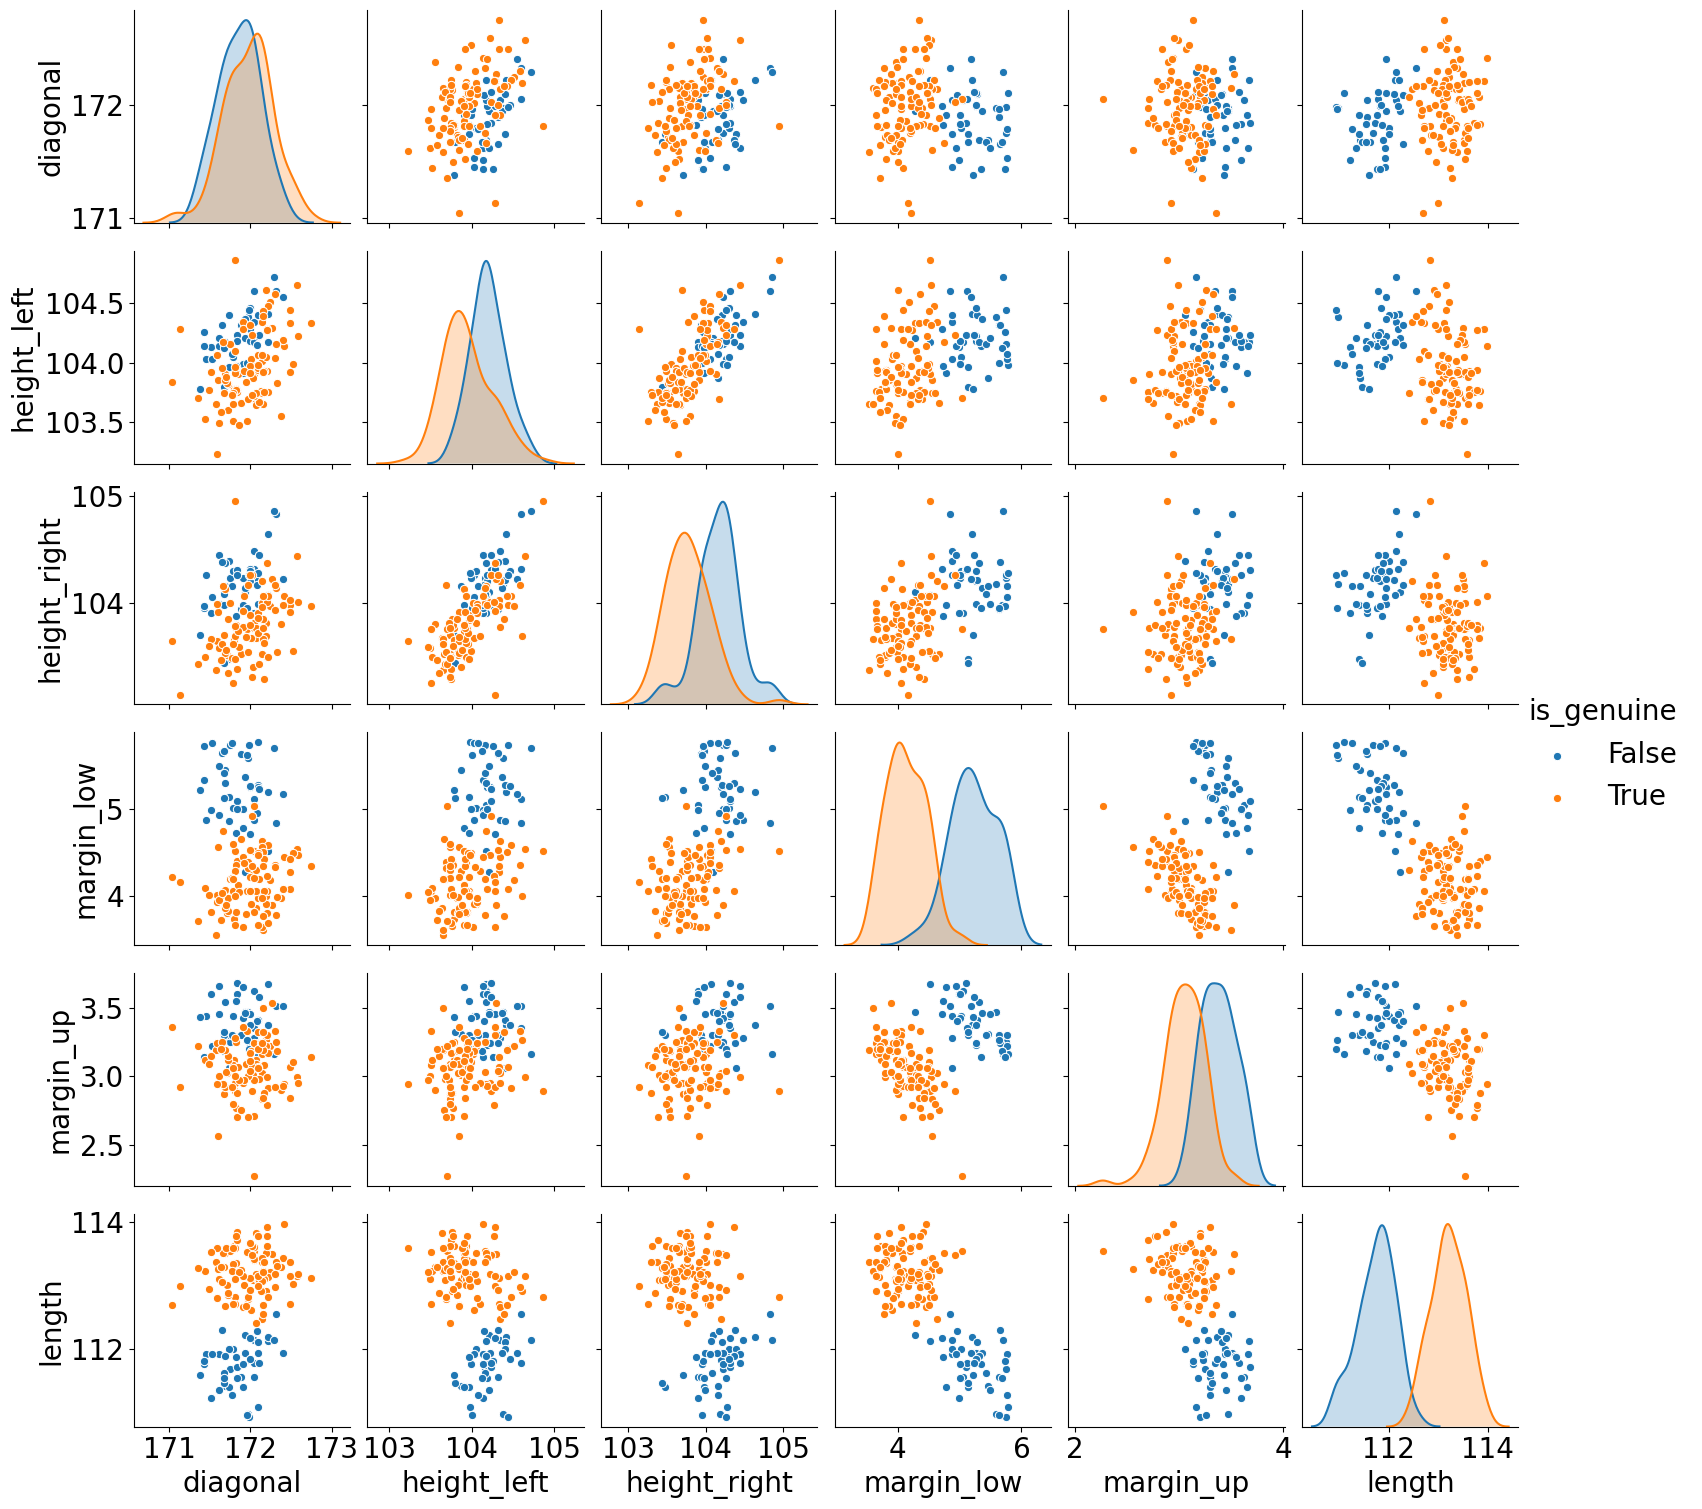

In [27]:
#dimension
# print(retained_data.shape) # 
#nombre d'observations
n = data.iloc[:, [0, 6, 4, 3]].shape[0]
#nombre de variables
p = data.iloc[:, [0, 6, 4, 3]].shape[1]


#classe pour standardisation
from sklearn.preprocessing import StandardScaler
#instanciation
sc = StandardScaler()
#transformation – centrage-réduction
Z = sc.fit_transform(data.iloc[:, [0, 6, 4, 3]])
# print(Z)


#vérification - librairie numpy que moyenne est nul (au erreur de troncature près) et que l'écart type = 1
import numpy
# #moyenne
# print(numpy.mean(Z,axis=0))
# #écart-type
# print(numpy.std(Z,axis=0,ddof=0))


#classe pour l'ACP
from sklearn.decomposition import PCA
#instanciation
acp = PCA(svd_solver='full')
#affichage des paramètres sélectionné
# print(acp)

#calculs des coordonnées 
coord = acp.fit_transform(Z)
#nombre de composantes calculées
# print(acp.n_components_) # 6


# Variance associé aux axe factoriel
eigval =acp.singular_values_**2/n
print(eigval)
#proportion de variance expliquée
print(acp.explained_variance_ratio_)

print("la 1er composante (length) représente 76% de l'information disponible; avec les 2 première composante nous avons 92% des informations")

sns.pairplot(data[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length", "is_genuine"]], hue='is_genuine');


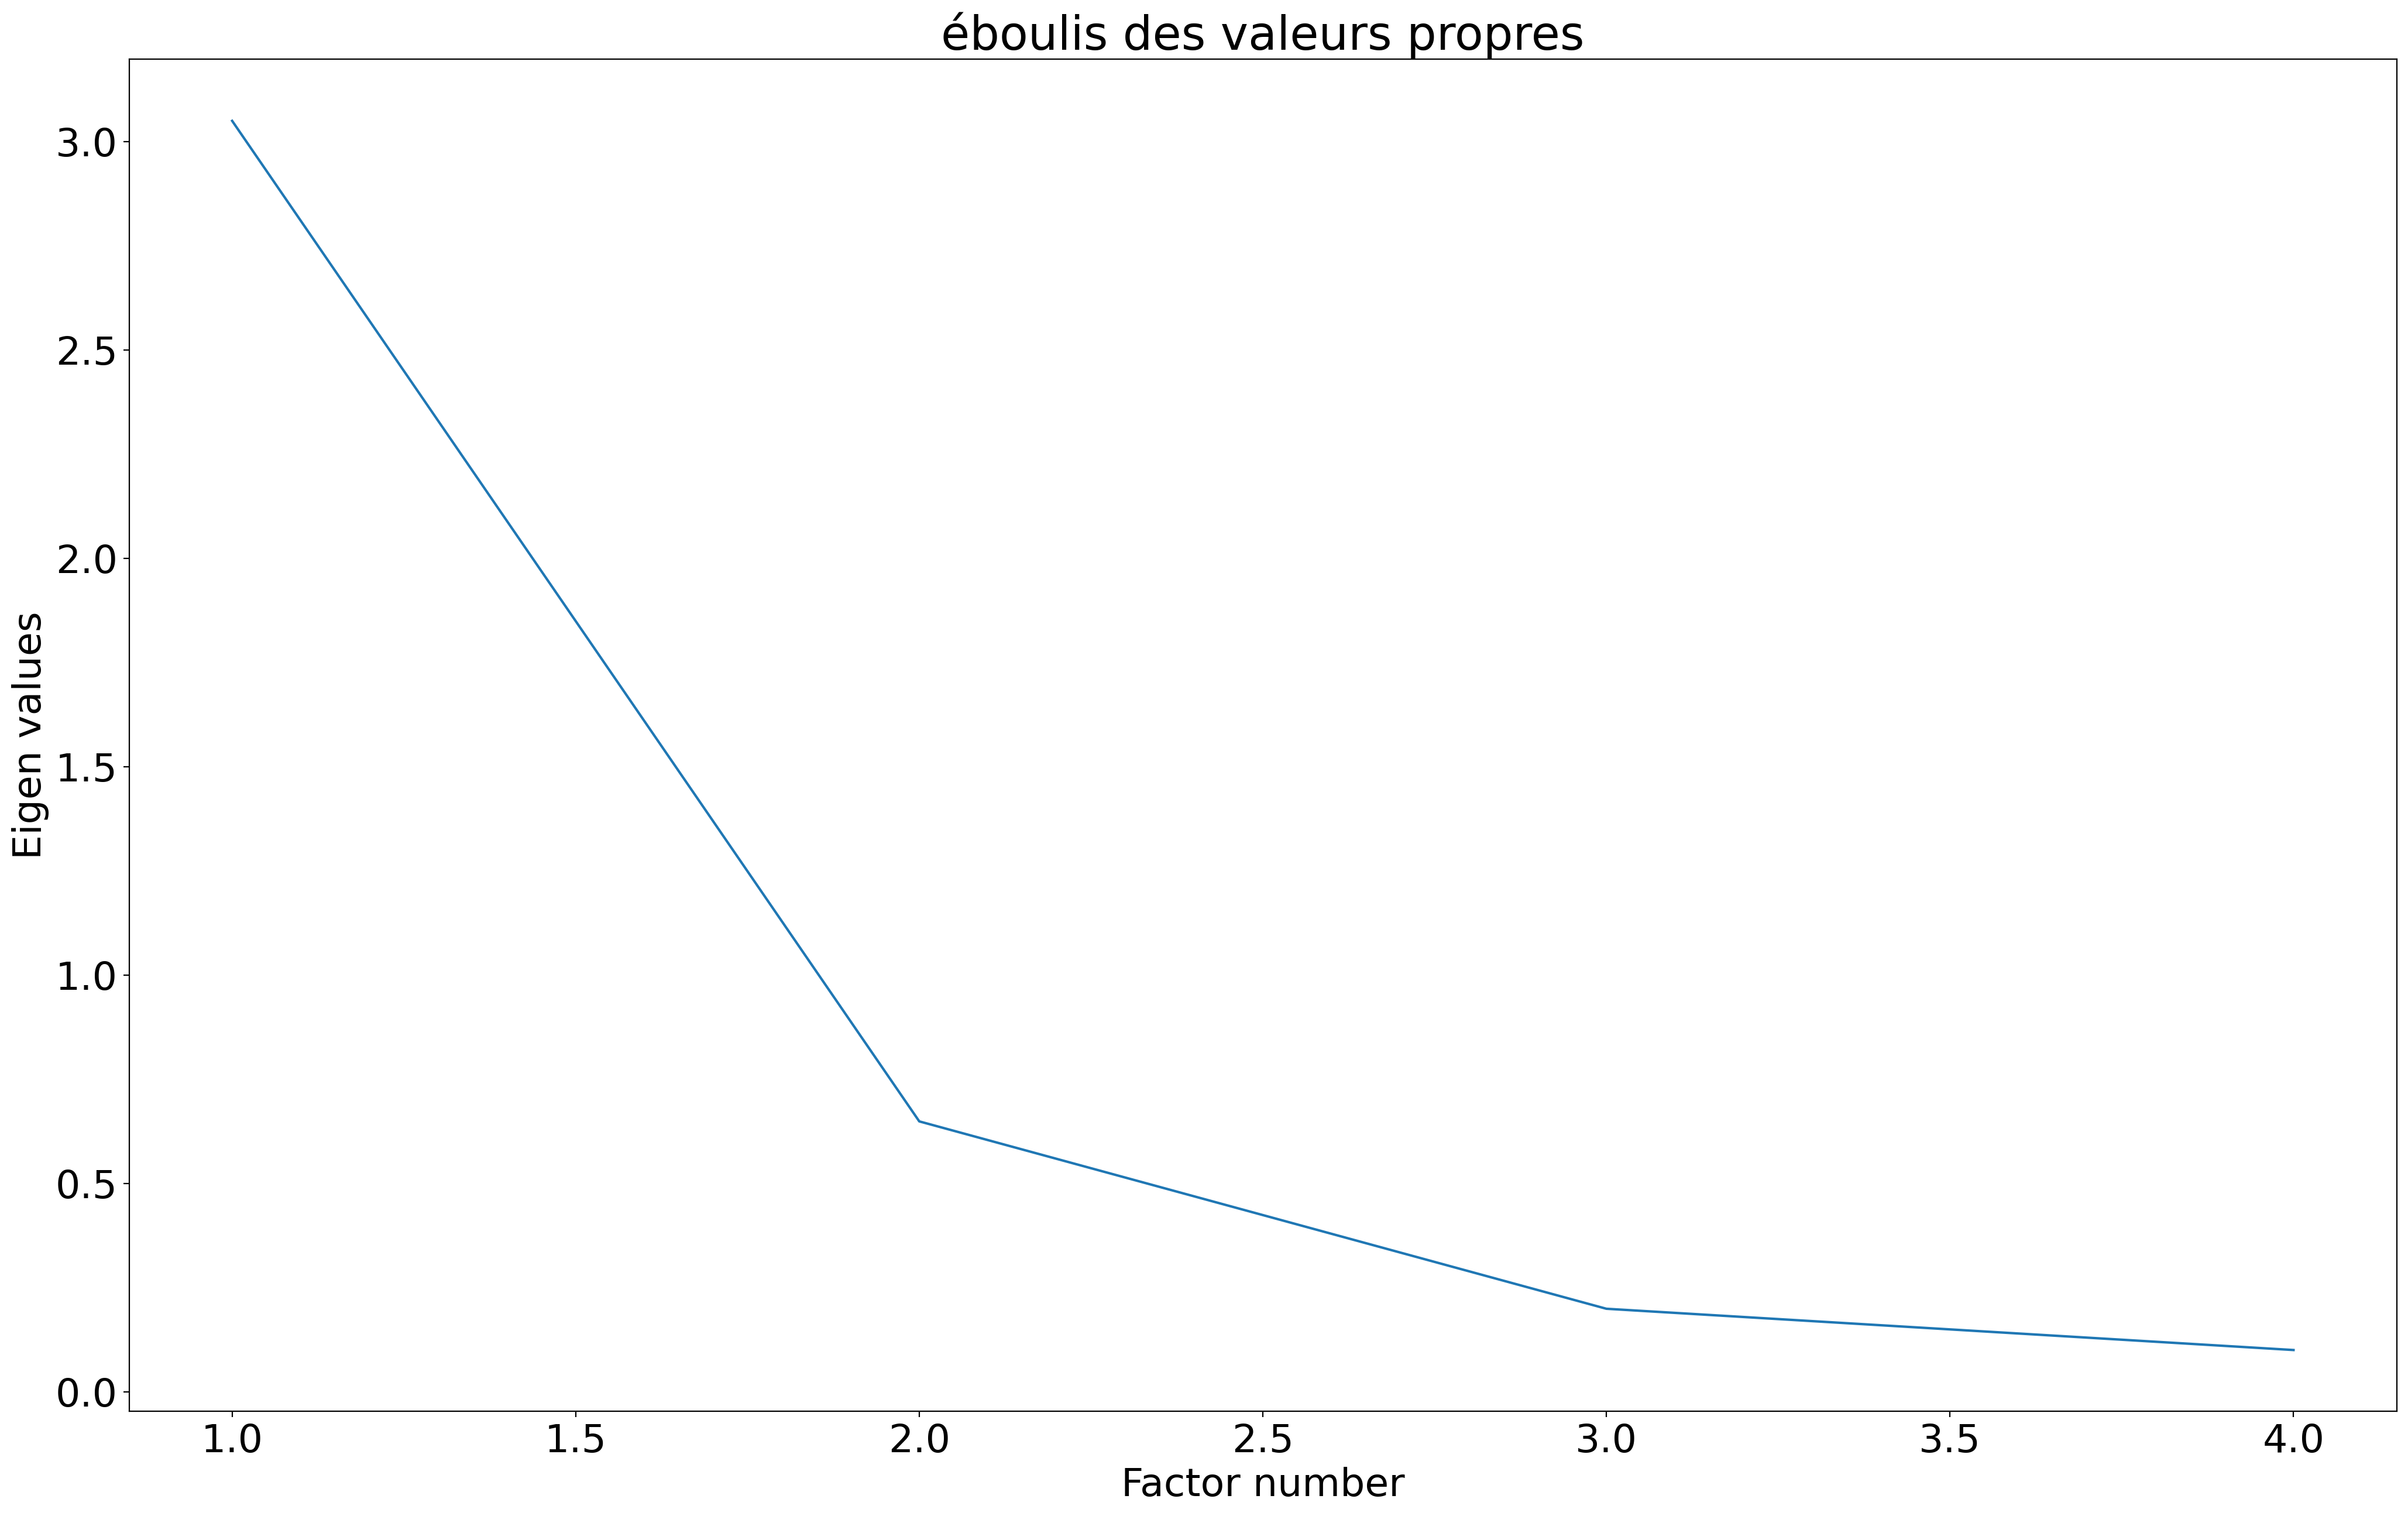

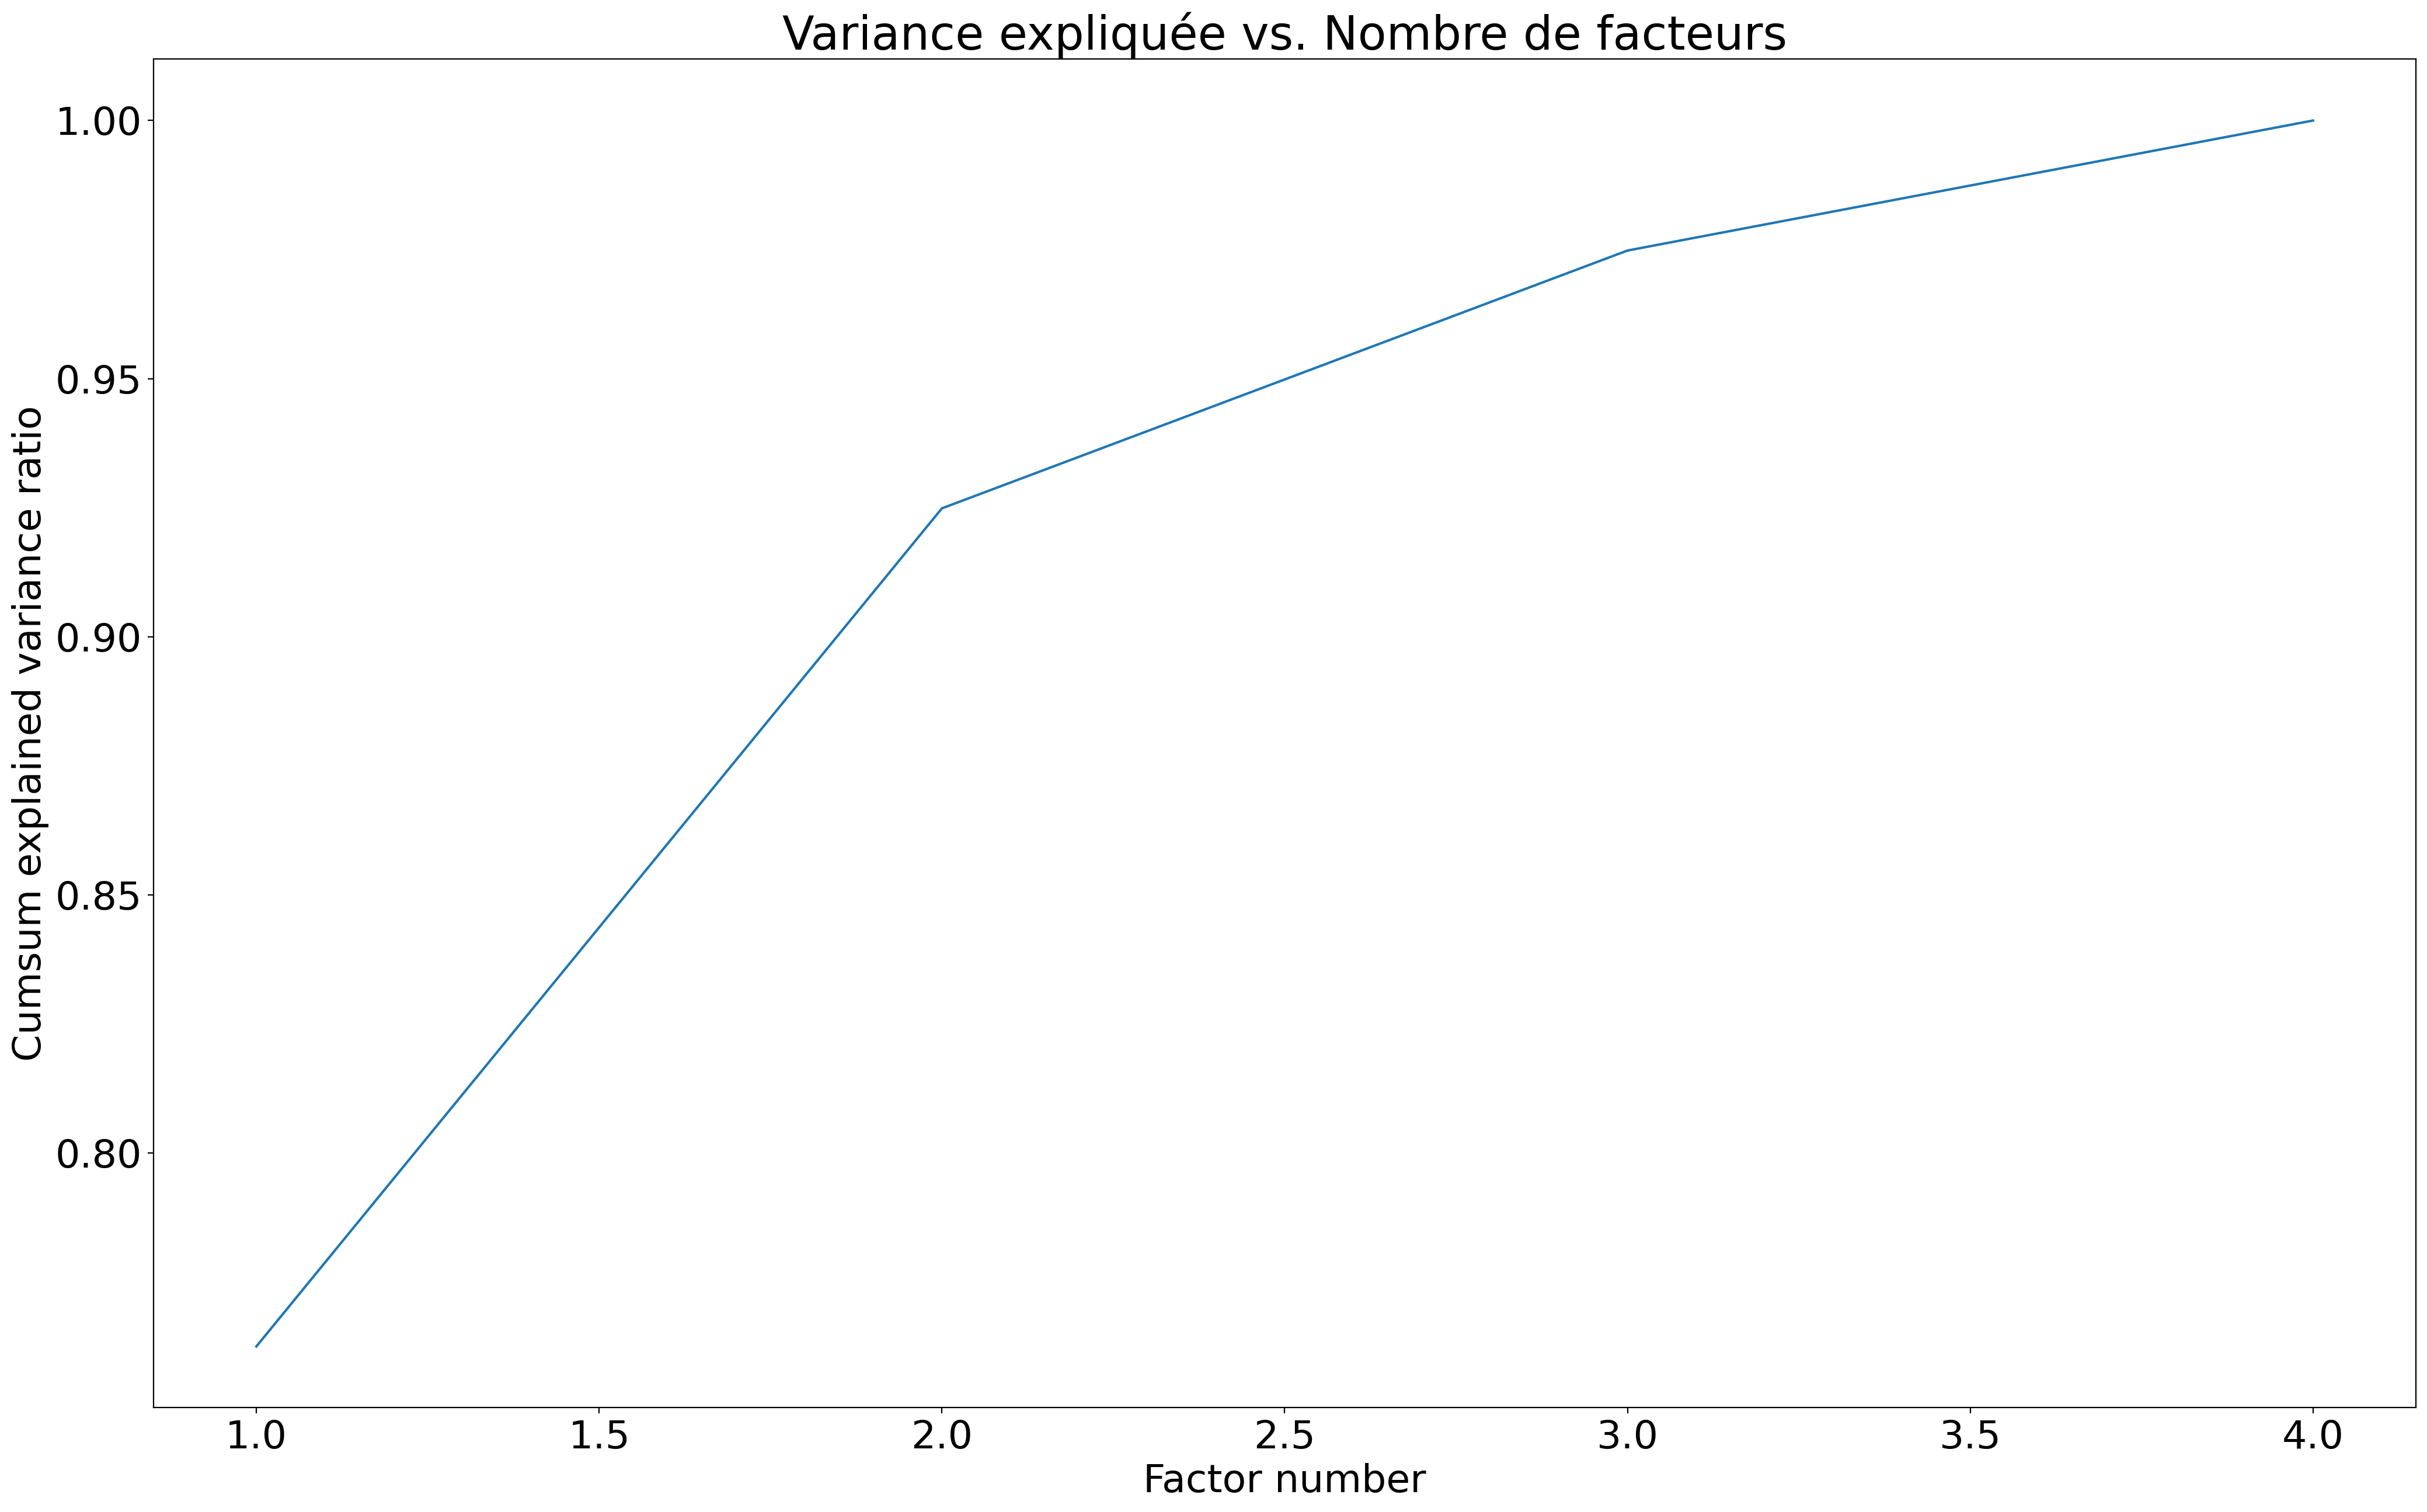

In [28]:



#graph ébouli des valeur propre
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(25,15), dpi=200)
plt.plot(numpy.arange(1,p+1),(acp.singular_values_**2/n))
plt.title("éboulis des valeurs propres")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()




#cumul de variance expliquée
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(25,15), dpi=200)
plt.plot(numpy.arange(1,p+1),numpy.cumsum(acp.explained_variance_ratio_))
plt.title("Variance expliquée vs. Nombre de facteurs")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
# plt.savefig("P05_Coriton_Jules/variance_explain.png")
plt.show()


## Réalisation d'un modèle prédictif avec un algo de classification (Kmeans)

In [29]:
# Utilisation de cluster pour observer si il y a des différences avec la catégorie de billet

In [30]:
from sklearn.cluster import KMeans

prediction = KMeans(n_clusters=2, random_state=0).fit_predict(data[['F1', 'F2']])
prediction = np.invert(prediction.astype('bool')) #inverse True & False to have same is_genuine

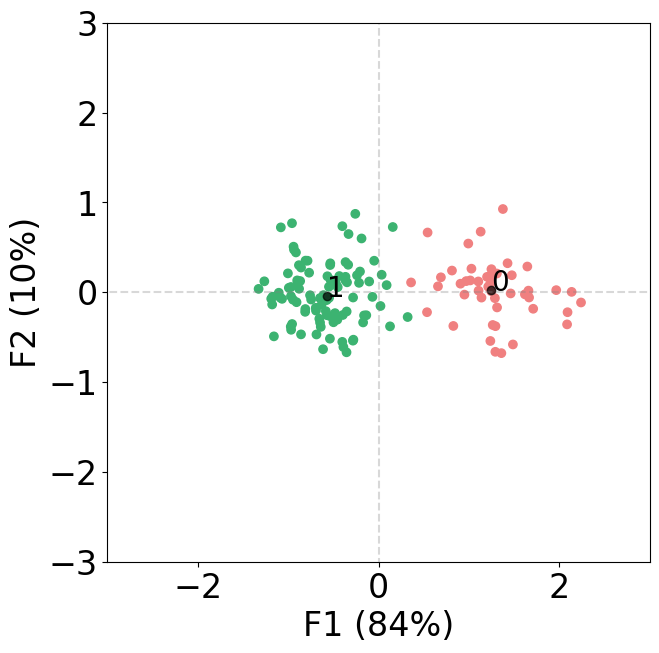

In [31]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=prediction, 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=False)


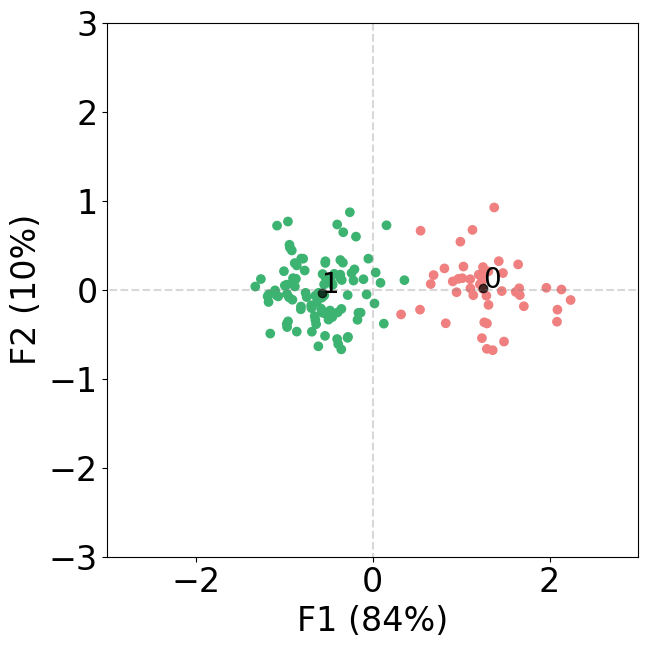

In [32]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=data['is_genuine'], 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=True)

In [33]:
# sns.pairplot(data[['is_genuine', 'F1', 'F2']], hue='is_genuine');

### compataison des résultats avec les données

In [34]:
print(metrics.confusion_matrix(y_true=data['is_genuine'], y_pred=prediction))
print('AUROC : ', metrics.roc_auc_score(y_true=data['is_genuine'], y_score=prediction))

# 1 Faux Négatif et un Faux Positif

[[45  1]
 [ 1 97]]
AUROC :  0.9840283939662822


### mise en place d'une méthode de comparaison 

In [35]:
# méthode pour analyser les qualité des prédiction d'un modèle

def confusion_matrix_sens_spec(model, y, X):
    import sklearn.metrics as metrics
    

    
    # model prediction
    prediction = model.predict_proba(X)[:,1]
    prediction_boolean = model.predict(X)

    # model scoring
    confusion_matrix = metrics.confusion_matrix(y_true=y, y_pred=prediction_boolean)                       
    print(confusion_matrix)

    print('sensitivity +', (confusion_matrix[1, 1] / 
                           (confusion_matrix[1, 1] + confusion_matrix[0, 1])))

    print('specificity -', (confusion_matrix[0, 0] / 
                           (confusion_matrix[0, 0] + confusion_matrix[1, 0])))
    
    print('AUROC score :',metrics.roc_auc_score(y_true=y, y_score=model.predict(X)))

    


## Réalisation d'un modèle prédictif (neighbor & gridsearch)

In [36]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X = data[['F1', 'F2']]
y = data['is_genuine']

# GridSearchCV
parameters_dictionnay = {'n_neighbors': np.arange(2, 11)}

grid = GridSearchCV(KNeighborsClassifier(metric='euclidean', 
                                         weights='distance'), parameters_dictionnay, cv=5)
grid.fit(X, y)

# scoring then modelling
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
print(model)
# prediction results
prediction = model.predict(X)

{'n_neighbors': 5}
0.993103448275862
KNeighborsClassifier(metric='euclidean', weights='distance')


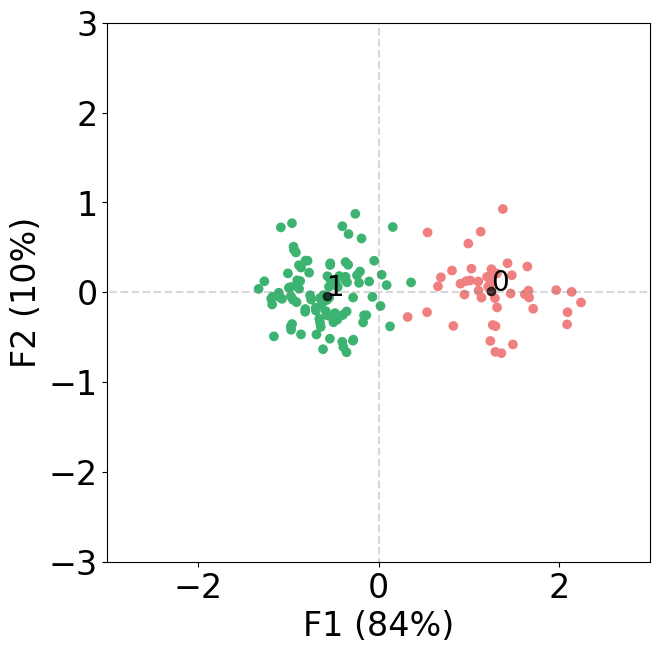

In [37]:
pca_factorial_plane(pca=pca, component_plane=[1, 2], groups=prediction, 
                    columns=chosen_columns,
                    labels=False, centroids=True,
                    savefig=False)


In [38]:

confusion_matrix_sens_spec(model, y=data['is_genuine'], X=data[['F1', 'F2']])


[[46  0]
 [ 0 98]]
sensitivity + 1.0
specificity - 1.0
AUROC score : 1.0


## Réalisation d'un modèle prédictif (regression logistique)

In [39]:
def logistic_regression(y, X):
    
    # model selection
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import GridSearchCV

    # X = select Feature, y = Target
    X = np.array(X)
    y = np.array(y).reshape(-1,1)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.2,
                                                        random_state=0)
 
    # GridSearchCV
    parameters_dictionnay = {'penalty': ['l1', 'l2', "elasticnet" 'none'],
                             'solver' : ['lbfgs', 'liblinear', "sag", "saga", "newton-cg"],
                             'class_weight' : ['none', 'balanced', "dict"],
                             'fit_intercept' : ['True', 'False']
                             }

    grid = GridSearchCV(LogisticRegression(), parameters_dictionnay, cv=10)
    grid.fit(X_train, y_train)
    
    # scoring then modelling
    print('GridSearchCV : ', grid.best_params_)
    model = grid.best_estimator_

    #model.fit(X_train,y_train)
    print('Coefficients : ', model.coef_)
    
    # model score
    print('Train score (CV 20):', cross_val_score(LogisticRegression(),
                                               X_train, y_train,
                                               cv=20).mean())

    print('Test score :', model.score(X_test, y_test))
    
    return model, X_test, y_test

In [40]:
model, X_test, y_test = logistic_regression(y=data['is_genuine'], X=data[['F1', 'F2']])
model.predict(X_test)

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validat

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "F:

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(

F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "F:\w10\Programme\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "F:\w10\Programme\Anaconda\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(

GridSearchCV :  {'class_weight': 'balanced', 'fit_intercept': 'True', 'penalty': 'l1', 'solver': 'liblinear'}
Coefficients :  [[-5.09659381  0.        ]]
Train score (CV 20): 0.9833333333333334
Test score : 1.0


F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
F:\w10\Programme\Anaconda\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

array([ True,  True,  True,  True, False, False,  True,  True, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True, False,  True,
       False, False])

In [41]:
confusion_matrix_sens_spec(model, y=data['is_genuine'], X=data[['F1', 'F2']])

[[46  0]
 [ 1 97]]
sensitivity + 1.0
specificity - 0.9787234042553191
AUROC score : 0.9948979591836735


In [42]:
data = pd.read_csv("notes.csv", sep=",") #lire fichier csv

chosen_columns = data[['length', 'margin_low', 'height_right']]
components, _ = pca_transformation(chosen_columns, 0.95)
pca_components(components, chosen_columns, data)
data
# components, pca = pca_transformation(chosen_columns, 0.95)
Proba_data_total =(model.predict_proba(data[['F1', 'F2']])[:,0]*100).round(1)

Proba_data_total[(Proba_data_total < 60) & (Proba_data_total > 40)]


array([58.1, 53.2, 57.9])

### enregistrement du modèle

In [43]:
from joblib import dump, load
dump(model, './normal.model') 
model = load('./normal.model')

model

LogisticRegression(class_weight='balanced', fit_intercept='True', penalty='l1',
                   solver='liblinear')

### mise en place d'une méthode de détection de faux billet

In [44]:
import warnings; warnings.simplefilter('ignore')

from joblib import load

# loading model
normal = load('./normal.model')

# loading test's notes
test_data = pd.read_csv('./example.csv')

# F1 F2 creation
chosen_columns = test_data[['height_right', 'margin_low', 'length']]
components, _ = pca_transformation(chosen_columns, 2)
pca_components(components, chosen_columns, test_data)


def testing_dataframe(dataframe, model):
    
    # probability column
    dataframe['prediction'] = (model.predict_proba(dataframe[['F1','F2']])[:,0]) * 100
    dataframe['prediction'] = dataframe['prediction'].round(2)

    # is_genuine column
    dataframe['is_genuine'] = np.where(dataframe['prediction'] >= 50, 1, 0)
    dataframe['is_genuine'] = dataframe['is_genuine'].astype('bool')

    # third step : visual result
    return dataframe[['id', 'prediction', 'is_genuine']].set_index('id')


testing_dataframe(test_data, normal)


,prediction,is_genuine
id,,
A_1,0.29,False
A_2,0.21,False
A_3,0.89,False
A_4,96.39,True
A_5,99.81,True


## Amélioration du modèle prédictif

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


data = pd.read_csv("notes.csv", sep=",") #lire fichier csv

X = np.array(data[["margin_low", "diagonal", "length", "margin_up"]])
y = np.array(data[["is_genuine"]]).reshape(-1,1)

    # train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2, random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


Lreg = LogisticRegression(penalty='l1', dual=False, fit_intercept=True, intercept_scaling=1, class_weight="balanced", random_state=None, solver='liblinear')
Lreg.fit(X_train, y_train)




print('Test score :', Lreg.score(X_test, y_test))
    

data["predict"] = Lreg.predict_proba(data[["margin_low", "diagonal", "length", "margin_up"]])[:, 1]


data["predict_bool"] = Lreg.predict(X)




Lreg.predict_proba(data[["margin_low", "diagonal", "length", "margin_up"]])[:, 1].round(2)


(136, 4) (34, 4) (136, 1) (34, 1)
Test score : 1.0


array([0.93, 0.99, 0.98, 0.99, 0.99, 0.87, 0.99, 1.  , 0.93, 0.72, 0.88,
       0.99, 0.92, 0.98, 0.98, 0.99, 0.99, 0.98, 0.96, 0.98, 0.95, 0.97,
       0.91, 0.92, 0.98, 0.95, 0.97, 0.82, 0.99, 1.  , 0.98, 0.99, 0.96,
       0.89, 0.86, 0.89, 0.99, 1.  , 0.99, 0.99, 0.99, 0.96, 0.96, 0.91,
       0.96, 0.97, 0.97, 0.99, 0.97, 0.99, 0.99, 0.88, 0.95, 0.98, 0.99,
       0.96, 0.8 , 0.98, 0.92, 0.97, 0.97, 0.99, 0.97, 0.94, 0.92, 0.66,
       0.98, 0.96, 0.98, 0.66, 0.79, 0.97, 0.94, 0.99, 0.99, 0.99, 0.94,
       0.97, 0.94, 0.99, 0.86, 0.99, 0.97, 0.95, 0.67, 0.87, 0.98, 0.95,
       0.98, 0.98, 0.98, 0.96, 0.99, 0.99, 0.98, 0.97, 0.85, 0.98, 0.87,
       0.99, 0.06, 0.  , 0.42, 0.14, 0.  , 0.03, 0.07, 0.04, 0.01, 0.03,
       0.46, 0.01, 0.06, 0.  , 0.03, 0.45, 0.  , 0.  , 0.04, 0.01, 0.01,
       0.  , 0.01, 0.03, 0.36, 0.03, 0.12, 0.01, 0.06, 0.01, 0.05, 0.  ,
       0.01, 0.01, 0.02, 0.  , 0.01, 0.07, 0.01, 0.03, 0.01, 0.03, 0.  ,
       0.02, 0.09, 0.02, 0.  , 0.03, 0.01, 0.02, 0.

### Analyse de l'efficacité du modèle 

In [46]:
confusion_matrix_sens_spec(Lreg, y=data['is_genuine'], X=data[["margin_low", "diagonal", "length", "margin_up"]])

[[ 70   0]
 [  0 100]]
sensitivity + 1.0
specificity - 1.0
AUROC score : 1.0


## Vérification du fonctionnement et du degré de précision sur des données test

In [47]:
   
    # loading test's notes
test_data = pd.read_csv('./example.csv')

test_data[["margin_low", "diagonal", "length", "margin_up"]]


chosen_columns = test_data[["margin_low", "diagonal", "length", "margin_up"]]


test_data["predict"] = Lreg.predict_proba(chosen_columns)[:, 1]
test_data["predict_bool"] = Lreg.predict(chosen_columns)



display(test_data[["id", "predict", "predict_bool"]])

test_data



,id,predict,predict_bool
0,A_1,0.021122,False
1,A_2,0.001543,False
2,A_3,0.031941,False
3,A_4,0.898915,True
4,A_5,0.990310,True


,diagonal,height_left,height_right,margin_low,margin_up,length,id,predict,predict_bool
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.021122,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.001543,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.031941,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.898915,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.990310,True


In [48]:
from joblib import dump, load
dump(Lreg, './normal.model') 
model = load('./normal.model')

model

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [49]:
import warnings; warnings.simplefilter('ignore')

from joblib import load

# loading model
model = load('./normal.model')

# loading test's notes
test_data = pd.read_csv('./example.csv')


def testing_dataframe(dataframe, model):
    
    # probability column
    dataframe['prediction'] = (model.predict_proba(dataframe[["margin_low", "diagonal", "length", "margin_up"]])[:, 1]) * 100
    dataframe['prediction'] = dataframe['prediction'].round(2)

    # is_genuine column
    dataframe['is_genuine'] = np.where(dataframe['prediction'] >= 50, 1, 0)
    dataframe['is_genuine'] = dataframe['is_genuine'].astype('bool')

    # third step : visual result
    return dataframe[['id', 'prediction', 'is_genuine']].set_index('id')


testing_dataframe(test_data, model)



,prediction,is_genuine
id,,
A_1,2.11,False
A_2,0.15,False
A_3,3.19,False
A_4,89.89,True
A_5,99.03,True


In [50]:
model
normal


LogisticRegression(class_weight='balanced', fit_intercept='True', penalty='l1',
                   solver='liblinear')

In [51]:
model

LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')

In [52]:
Proba_data_total =(model.predict_proba(data[["margin_low", "diagonal", "length", "margin_up"]])[:,0]*100).round(1)

Proba_data_total[(Proba_data_total < 60) & (Proba_data_total > 40)]


array([58.5, 53.8, 54.9])